In [44]:
%matplotlib inline

# import
import numpy
import pandas as pd
import autograd_extended
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import LSTM, Input, Lambda, Dense, RepeatVector
from keras import backend as K
from keras import objectives

import scipy.integrate

import autograd.numpy as np
from autograd import make_vjp, grad
from autograd.extend import primitive, defvjp_argnums
from autograd.misc import flatten
from autograd.builtins import tuple
from autograd.misc.optimizers import adam

odeint = primitive(scipy.integrate.odeint)

# Training the latent ODE model
<strong>From appendix D</strong>

To obtain the latent representation $z_{t_{0}}$, we traverse using RNN and obtain parameters of distribution $ q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}, \theta_{enc})$. The algorithm is the following:


## Step 1
Run an RNN encoder through the time series and infer the parameters for the a posterior over $ \textbf{z}_{t_{0}}$:
$$ q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}, \phi) = \mathcal{N}(\textbf{z}_{t_{0}} | \mu_{\textbf{z}_{t_{0}}}, \sigma_{\textbf{z}_{0}}) $$

where $\mu_{z_{0}}, \sigma_{z_{0}}$ comes from hidden state of $ RNN(\{ \textbf{x}_{t_{i}} , t_{i} \}_{i}, \phi) $

## Step 2
Sample $ \textbf{z}_{t_{0}} \sim q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}) $

In [45]:
# Process Data

# obtain simple time series with sine function
df = pd.read_csv('./data.csv')

x, y = df["x"], df["y"]

# split y into timesteps for training (-1, 100, 1) we use a sliding window
timesteps = 5

newY = []
for i in range(0, len(y)-timesteps):
    temp = y[i:i+timesteps]
    
    temp_ls = []
    for j in temp:
        temp_ls.append([j])
    newY.append(temp_ls)
    
y = np.array(newY)

Define and run the autoencoder model

In [46]:
# Run an RNN encoder on the time series

# Params
timesteps = 5
input_dim = 1
lstm_dim = 32
latent_dim = 100
batch_size = 1

# Encoder model
def sample_z(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# Input
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

# LSTM encoding
h = LSTM(lstm_dim)(inputs)

# VAE Z layer
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# Obtain z
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_log_sigma])

# Encoder for sanity checking
encoder = Model(inputs, z_mean, name="encoder")

# Encoder to extract z values
encoder_z = Model(inputs, z, name="encoder_z")

# Decoder model
decoder_h = LSTM(lstm_dim, return_sequences=True)
decoder_mean = LSTM(input_dim, return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

# decoded layer
outputs = decoder_mean(h_decoded)

# decoder, from latent space to reconstructed inputs
decoder_inputs = Input(shape=(latent_dim,))

_h_decoded = RepeatVector(timesteps)(decoder_inputs)
_h_decoded = decoder_h(_h_decoded)

decoder_outputs = decoder_mean(_h_decoded)

decoder = Model(decoder_inputs, decoder_outputs)

# Build vae
vae = Model(inputs, outputs, name='vae_lstm')
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss

vae.compile(optimizer='adam', loss=vae_loss)

# Uncomment to print a summary
# encoder.summary()
# decoder.summary()
# vae.summary()

# Train the VAE to obtain z
vae.fit(y, y, epochs=20)

Epoch 1/20
1995/1995 [==============================] - 6s 3ms/step - loss: 0.5040
Epoch 2/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.4752
Epoch 3/20
1995/1995 [==============================] - 2s 999us/step - loss: 0.4647
Epoch 4/20
1995/1995 [==============================] - 2s 983us/step - loss: 0.4599
Epoch 5/20
1995/1995 [==============================] - 2s 926us/step - loss: 0.4488
Epoch 6/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.4069
Epoch 7/20
1995/1995 [==============================] - 2s 942us/step - loss: 0.3175
Epoch 8/20
1995/1995 [==============================] - 2s 995us/step - loss: 0.2431
Epoch 9/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.2179
Epoch 10/20
1995/1995 [==============================] - 2s 950us/step - loss: 0.2021
Epoch 11/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.1881
Epoch 12/20
1995/1995 [==============================] - 2s 1ms/step - lo

x: (1995, 5, 1), preds: (1995, 5, 1)


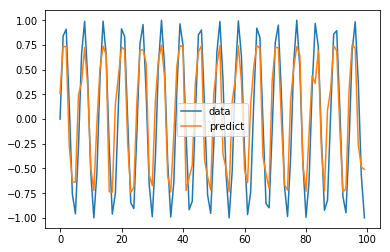

In [47]:
# Sanity check, we should get a sine graph
prediction = vae.predict(y, batch_size=batch_size)

# pick a column to plot.
print("x: %s, preds: %s" % (y.shape, prediction.shape))
plt.plot(y[:100,0,0], label='data')
plt.plot(prediction[:100,0,0], label='predict')
plt.legend()
plt.show()

## Step 3
Obtain $\textbf{z}_{t_{1}}, \textbf{z}_{t_{2}}, ..., \textbf{z}_{t_{M}} $ by solving ODE $ ODESolve(\textbf{z}_{t_{0}}, f, \theta_{f}, t_{0},...,t_{M})$ where $f$ is the function defining the gradient $d\textbf{z}/{dt}$ as a function of $\textbf{z}$

In [48]:
# We obtain z values from the prior sample by using the predict function
# As the dataset here is small we just use all y values
z_val = encoder_z.predict(y)
print(prediction.shape)
print(z_val)

(1995, 5, 1)
[[-0.96730685 -0.30260754 -1.2165959  ... -0.1712243   0.16253346
   0.1311233 ]
 [ 0.8523834   1.3523002  -0.5332169  ...  0.5856302   0.80972576
  -0.4475613 ]
 [ 1.7198956   1.1818202  -0.38006347 ... -0.61021274 -0.8827091
  -1.177722  ]
 ...
 [ 1.5871499   0.38149977 -1.2908301  ...  1.5604678  -1.1208996
  -0.05023703]
 [ 0.60470605  2.166283    0.07132202 ... -0.35144055 -1.2759343
  -1.1601465 ]
 [-0.84649354 -0.5831001  -0.44895828 ...  1.4420025   0.8956648
  -2.1960166 ]]


In [49]:
# From Appendix B
# For clarity: vjp stands for Vector Jacobian Product

def grad_odeint_all(yt, func, y0, t, func_args, **kwargs):
    """
    Extended from "Scalable Inference of Ordinary Differential"
    Equation Models of Biochemical Processes". Sec. 2.4.2
    Fabian Froehlich, Carolin Loos, Jan Hasenauer, 2017
    https://arxiv.org/pdf/1711.08079.pdf
    """
    T, D = np.shape(yt)
    flat_args, unflatten = flatten(func_args)
    
    def flat_func(y, t, flat_args):
        return func(y, t, *unflatten(flat_args))

    def unpack(x):
        #      y,      vjp_y,      vjp_t,    vjp_args
        return x[0:D], x[D:2 * D], x[2 * D], x[2 * D + 1:]

    def augmented_dynamics(augmented_state, t, flat_args):
        """
        Original system augemented with vjp_y, vjp_t and vjp_args 
        """
        y, vjp_y, _, _ = unpack(augmented_state)
        vjp_all, dy_dt = make_vjp(flat_func, argnum=(0, 1, 2))(y, t, flat_args)
        vjp_y, vjp_t, vjp_args = vjp_all(-vjp_y)
        return np.hstack((dy_dt, vjp_y, vjp_t, vjp_args))

    def vjp_all(g):
        vjp_y = g[-1, :]
        vjp_t0 = 0
        time_vjp_list = []
        vjp_args = np.zeros(np.size(flat_args))
        
        for i in range(T - 1, 0, -1):

            # Compute effect of moving measurement time.
            vjp_cur_t = np.dot(func(yt[i, :], t[i], *func_args), g[i, :])
            time_vjp_list.append(vjp_cur_t)
            vjp_t0 = vjp_t0 - vjp_cur_t

            # Run augmented system backwards to the previous observation.
            aug_y0 = np.hstack((yt[i, :], vjp_y, vjp_t0, vjp_args))
            aug_ans = odeint(augmented_dynamics, aug_y0,
                             np.array([t[i], t[i - 1]]), tuple((flat_args,)), **kwargs)
            _, vjp_y, vjp_t0, vjp_args = unpack(aug_ans[1])

            # Add gradient from current output.
            vjp_y = vjp_y + g[i - 1, :]

        time_vjp_list.append(vjp_t0)
        vjp_times = np.hstack(time_vjp_list)[::-1]

        return None, vjp_y, vjp_times, unflatten(vjp_args)
    return vjp_all


def argnums_unpack(all_vjp_builder):
    """
    A generic autograd helper function.  Takes a function that
    builds vjps for all arguments, and wraps it to return only required vjps.
    """

    def build_selected_vjps(argnums, ans, combined_args, kwargs):
        vjp_func = all_vjp_builder(ans, *combined_args, **kwargs)

        def chosen_vjps(g):  # Returns whichever vjps were asked for.
            all_vjps = vjp_func(g)
            return [all_vjps[argnum] for argnum in argnums]
        return chosen_vjps
    return build_selected_vjps


# After performing defvjp_argnums, we can use odeint() as a function anywhere now
# Details of implementation found in autograd library
# https://github.com/HIPS/autograd/blob/master/autograd/core.py

defvjp_argnums(odeint, argnums_unpack(grad_odeint_all))

In [55]:
# define f as sin function
f = lambda y, t0, z: np.dot(np.sin(y), z)

t = np.linspace(0., max_T, N)
# odeint(yt, func, y0, t)

# TODO

## Step 4
Maximize ELBO (Evidence Lower Bound) 
$$ ELBO = \sum^{M}_{i=1}
        {
             \log p(\textbf{x}_{t_{i}}) | \textbf{z}_{t_{i}}, \theta_{\textbf{x}} ) 
             + \log p(\textbf{z}_{t_{0}})
             - \log q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}, \phi)
        }  
$$

Where $p(\textbf{z}_{t_{0}}) = \mathcal{N}(0,1)$

In [54]:
# TODO